# NER with BiLSTM CNN CRF for NER
Nous utiliserons le codage par réseau neuronal à convolution pour la représentation des mots au niveau des caractères, le LSTM bidirectionnel pour le codage au niveau des mots et les champs aléatoires conditionnels (couche CRF) pour les décodages de sortie.

Réference [model](https://github.com/ZhixiuYe/NER-pytorch)

In [1]:
import tensorflow as tf
import keras
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D,Flatten, concatenate
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.layers.crf import CRF
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
import numpy as np
import os
import sys
import codecs
import re
import pickle
from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data Preprocessing

Data prepocessing comprend le chargement des données, la mise à jour du schéma de balisage, la création d'un mappong pour les mots, les caractères et les tags et enfin la préparation des données qui sont transmises dans le modèle.


### Custom Data Loading
Cette étape comprend le chargement du train et la validation des données dans la liste des phrases. 

Le code suivant charge les données de formation et de validation.

In [2]:
# def load_sentences(filename):
#     f = open(filename)
#     sentences = []
#     sentence = []
#     for line in f:
#         if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
#             if len(sentence) > 0:
#                 sentences.append(sentence)
#                 sentence = []
#             continue
#         splits = line.split(' ')
#         sentence.append([splits[0], splits[-1]])

#     if len(sentence) > 0:
#         sentences.append(sentence)
#         sentence = []
#     return sentences

In [3]:
import csv
def corpus_preprocessing(path):
    pairwise = dict()
  
    paths = [path]
    sentences = []
    sentence = []
    p_token = ''

    all_length = []
    length = 0
    longer_entity = 0
    max_length = 0
    entity_count = 0
    labels_list = []
    tokens_list =[]
    tag_list =[]
    for path in paths:
        with open(path) as fin:
            reader = csv.reader(fin, delimiter='\t', quoting=csv.QUOTE_NONE)
            entity_length_turn_on = False
            for i, row in enumerate(reader):
                if i == 0:
                    pass
                if len(row) < 2:
                    sentences.append(sentence)
                    sentence = []
                else:
                    token = row[0]
                    label = row[1]
                    #tag = row[1]

                    labels_list.append(label)
                    #tag_list.append(tag)
                    tokens_list.append(token)
    #return list(zip(tokens_list,labels_list))
    return [list([ele]) for ele in list(zip(tokens_list,labels_list))] 

In [4]:
train_sentences = corpus_preprocessing("NCBI_corpus/train.tsv")
dev_sentences = corpus_preprocessing("NCBI_corpus/devel.tsv")
test_sentences = corpus_preprocessing("NCBI_corpus/test.tsv")
len(train_sentences), len(dev_sentences), len(test_sentences)

(135701, 23969, 24497)

In [5]:
train_sentences[0:20]

[[('Identification', 'O')],
 [('of', 'O')],
 [('APC2', 'O')],
 [(',', 'O')],
 [('a', 'O')],
 [('homologue', 'O')],
 [('of', 'O')],
 [('the', 'O')],
 [('adenomatous', 'B-Disease')],
 [('polyposis', 'I-Disease')],
 [('coli', 'I-Disease')],
 [('tumour', 'E-Disease')],
 [('suppressor', 'O')],
 [('.', 'O')],
 [('The', 'O')],
 [('adenomatous', 'B-Disease')],
 [('polyposis', 'I-Disease')],
 [('coli', 'I-Disease')],
 [('(', 'I-Disease')],
 [('APC', 'I-Disease')]]

### Add Character Information

In [6]:
def add_char_info(sentences):
    for i, sentence in enumerate(sentences):
        for j, data in enumerate(sentence):
            chars = [c for c in data[0]]
            sentences[i][j] = [data[0], chars, data[1]]
    return sentences

In [7]:
#add_char_info(train_sentences)
#train_sentences

In [8]:
train_sentences = add_char_info(train_sentences)
dev_sentences = add_char_info(dev_sentences)
test_sentences = add_char_info(test_sentences)

### Tag Mappings

In [9]:
labels_set = set()
words = {}

# unique words and labels in data  
for dataset in [train_sentences, dev_sentences, test_sentences]:
    for sentence in dataset:
        for token, char, label in sentence:
        # token ... token, char ... list of chars, label ... BIO labels   
            labels_set.add(label)
            words[token.lower()] = True

In [10]:
labels_set

{'B-Disease', 'E-Disease', 'I-Disease', 'O', 'S-Disease'}

In [11]:
# mapping for labels
indexes = {"PADDING":0}
for label in labels_set:
  indexes[label] = len(indexes)

  
tag_to_id = {}
for word,index in indexes.items():
    tag_to_id[word] = index

tag_to_id

{'PADDING': 0,
 'S-Disease': 1,
 'B-Disease': 2,
 'E-Disease': 3,
 'O': 4,
 'I-Disease': 5}

In [12]:
id_to_tag = {v: k for k, v in tag_to_id.items()}
len(id_to_tag)

6

### Word and Character Embeddings

In [13]:
# Download Glove Word Embeddings
#!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip -d /content/

In [14]:
word_to_id = {}
word_embeddings = []

EMBEDDINGS_FILE = open("data/glove.6B.50d.txt", encoding="utf-8")


# loop through each word in embeddings
for line in EMBEDDINGS_FILE:
    split = line.strip().split(" ")
    word = split[0]  # embedding word entry

    if len(word_to_id) == 0:  # add padding+unknown
        word_to_id["PADDING_TOKEN"] = len(word_to_id)
        vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
        word_embeddings.append(vector)

        word_to_id["UNKNOWN_TOKEN"] = len(word_to_id)
        vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
        word_embeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        word_embeddings.append(vector)  # word embedding vector
        word_to_id[split[0]] = len(word_to_id)  # corresponding word dict

word_embeddings = np.array(word_embeddings)
word_embeddings.shape, len(word_to_id)

((7618, 50), 7618)

In [15]:
id_to_word = {v: k for k, v in word_to_id.items()}
len(id_to_word)

7618

In [16]:
# Dictionnaire de tous les caractères possibles
char_to_id = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char_to_id[c] = len(char_to_id)

len(char_to_id)

97

### Prepare Dataset

In [17]:
def create_dataset(sentences, word_to_id, tag_to_id, char_to_id):
    unk_index = word_to_id['UNKNOWN_TOKEN']
    pad_index = word_to_id['PADDING_TOKEN']

    dataset = []

    word_count = 0
    unk_word_count = 0

    for sentence in sentences:
        word_indices = []
        char_indices = []
        tag_indices = []

        for word, char, tag in sentence:
            word_count += 1
            if word in word_to_id:
                word_index = word_to_id[word]
            elif word.lower() in word_to_id:
                word_index = word_to_id[word.lower()]
            else:
                word_index = unk_index
                unk_word_count += 1
            char_index = []
            for x in char:
                char_index.append(char_to_id[x])
            # Get the label and map to int
            word_indices.append(word_index)
            char_indices.append(char_index)
            tag_indices.append(tag_to_id[tag])

        dataset.append([word_indices, char_indices, tag_indices])

    return dataset

In [18]:
def padding(sentences):
    maxlen = 52
    for sentence in sentences:
        char = sentence[1]
        for x in char:
            maxlen = max(maxlen, len(x))
    for i, sentence in enumerate(sentences):
        sentences[i][1] = keras.preprocessing.sequence.pad_sequences(sentences[i][1], 52, padding='post')
    return sentences

In [19]:
train_set = padding(create_dataset(train_sentences, word_to_id, indexes, char_to_id))
dev_set = padding(create_dataset(dev_sentences, word_to_id, indexes, char_to_id))
test_set = padding(create_dataset(test_sentences, word_to_id, indexes, char_to_id))


In [20]:
def unpack(dataset):
    words=[]
    chars=[]
    tags = []
    for word, char, tag in dataset:
        words.append(word)
        chars.append(char)
        tags.append(tag)
  
    words = keras.preprocessing.sequence.pad_sequences(words, 52, padding='post')
    chars = keras.preprocessing.sequence.pad_sequences(chars, 52, padding='post')
    tags = keras.preprocessing.sequence.pad_sequences(tags, 52, padding='post')
    tags = keras.utils.to_categorical(tags, num_classes=10)
    return words, chars, tags

In [21]:
train_words, train_chars, train_tags = unpack(train_set)
valid_words, valid_chars, valid_tags = unpack(dev_set)
test_words, test_chars, test_tags = unpack(test_set)

In [22]:
train_words.shape, train_chars.shape, train_tags.shape

((135701, 52), (135701, 52, 52), (135701, 52, 10))

## Define Model
Le modèle qui est mis en œuvre dans ce projet utilise les architectures suivantes:
- Convolution Neural Network pour le niveau de caractère Représentation des mots
- Bidirectional LSTM pour le Word Encoding
- Conditional Random Fields (CRF Layer) pour output decodings.

In [23]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
# Define Model Layers
char_input = Input(shape=(None, 52,), name="char_input")
char_embed = TimeDistributed(Embedding(len(char_to_id), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="char_embed")(char_input)
char_dropout = Dropout(0.5)(char_embed)
char_cnn = TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same', activation='tanh', strides=1), name="conv1d")(char_dropout)
maxpool_out = TimeDistributed(MaxPooling1D(52), name="maxpool")(char_cnn)
char_flat = TimeDistributed(Flatten(), name="flatten")(maxpool_out)
char = Dropout(0.5)(char_flat)
words_input = Input(shape=(None,), dtype='int32', name='words_input')
words = Embedding(input_dim=word_embeddings.shape[0], output_dim=word_embeddings.shape[1], weights=[word_embeddings],trainable=False)(words_input)
concat = concatenate([words, char])
lstm = Bidirectional(LSTM(200, return_sequences=True, dropout=0.5,recurrent_dropout=0.25), name="bilstm")(concat)
out = TimeDistributed(Dense(len(tag_to_id), activation='softmax'),name="softmax_layer")(lstm)
crf_layer = CRF(10)
output = crf_layer(out)

# Define Model Inputs and Output
model = keras.models.Model([char_input,words_input],output)
# Compile Model
model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
# Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embed (TimeDistributed)    (None, None, 52, 30) 2910        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 30) 0           char_embed[0][0]                 
__________________________________________________________________________________________________
conv1d (TimeDistributed)        (None, None, 52, 30) 2730        dropout_1[0][0]                  
____________________________________________________________________________________________

In [25]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Training

In [26]:
history = model.fit([train_chars,train_words], train_tags,validation_data=[[valid_chars, valid_words], valid_tags],batch_size=64,epochs=30,verbose=1)

/home/user/anaconda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 135701 samples, validate on 23969 samples
Epoch 1/30
135701/135701 [==============================] - 628s 5ms/step - loss: 0.3141 - crf_viterbi_accuracy: 0.9525 - val_loss: 0.0355 - val_crf_viterbi_accuracy: 0.9985
Epoch 2/30
135701/135701 [==============================] - 567s 4ms/step - loss: 0.0272 - crf_viterbi_accuracy: 0.9984 - val_loss: 0.0216 - val_crf_viterbi_accuracy: 0.9985
Epoch 3/30
135701/135701 [==============================] - 496s 4ms/step - loss: 0.0151 - crf_viterbi_accuracy: 0.9984 - val_loss: 0.0158 - val_crf_viterbi_accuracy: 0.9987
Epoch 4/30
135701/135701 [==============================] - 493s 4ms/step - loss: -0.0057 - crf_viterbi_accuracy: 0.9985 - val_loss: -0.0220 - val_crf_viterbi_accuracy: 0.9987
Epoch 5/30
135701/135701 [==============================] - 491s 4ms/step - loss: -0.0414 - crf_viterbi_accuracy: 0.9985 - val_loss: -0.0628 - val_crf_viterbi_accuracy: 0.9987
Epoch 6/30
135701/135701 [==============================] - 503s 4ms/step -

## Training and Testing Accuracy

In [27]:
_, train_acc = model.evaluate([train_chars, train_words],train_tags)
_, val_acc = model.evaluate([valid_chars, valid_words], valid_tags)
_, test_acc = model.evaluate([test_chars, test_words],test_tags)

print('Training Accuray: ', train_acc * 100)
print('Validation Accuray: ', val_acc * 100)
print('Testing Accuray: ', test_acc * 100)

24497/24497 [==============================] - 29s 1ms/step
Training Accuray:  99.90959763526917
Validation Accuray:  99.90414381027222
Testing Accuray:  99.90224838256836


In [28]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Evaluation Metrics Report
Now we will use Precision, Recall and F1 score to evaluate the performance of our model on each tag.

In [29]:
# Evaluate
pred_cat = model.predict([test_chars,test_words])
predicted = [[[np.argmax(i)] for i in w] for w in pred_cat]
predicted = np.array(predicted)
actual = [[[np.argmax(i)] for i in w] for w in test_tags]
actual = np.array(actual)
# Convert the index to tag
predicted_tag = [[id_to_tag[i[0]] for i in row] for row in predicted]
actual_tag = [[id_to_tag[i[0]] for i in row] for row in actual]

# Metrics Report
report = flat_classification_report(y_pred=predicted_tag, y_true=actual_tag)
print(report)

              precision    recall  f1-score   support

   B-Disease       0.65      0.48      0.55       537
   E-Disease       0.64      0.74      0.68       537
   I-Disease       0.63      0.16      0.26       550
           O       0.97      0.99      0.98     22450
     PADDING       1.00      1.00      1.00   1249347
   S-Disease       0.68      0.75      0.71       423

    accuracy                           1.00   1273844
   macro avg       0.76      0.69      0.70   1273844
weighted avg       1.00      1.00      1.00   1273844



## Accuracy Curve

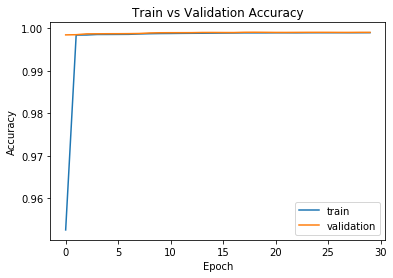

In [31]:
# Plotting Training vs Validation Accuracy
plt.plot(history.history['crf_viterbi_accuracy'])  
plt.plot(history.history['val_crf_viterbi_accuracy'])  
plt.title('Train vs Validation Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation']) 
plt.show()

## Loss Curve

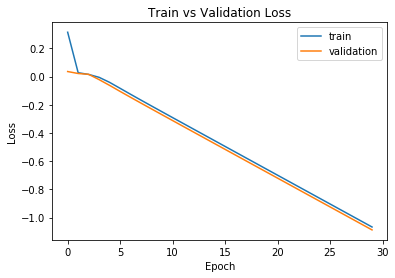

In [32]:
# Plotting Training vs Validation Accuracy
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Train vs Validation Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation']) 
plt.show()

## Testing

In [33]:
good_example = []
bad_example = []

for i in range(1000):
    for j in range(1):
        if test_words[i][j] != 0:
            word = id_to_word[test_words[i][j]]
            a_tag = actual_tag[i][j]
            p_tag = predicted_tag[i][j]
        if a_tag == p_tag:
            good_example.append([word, p_tag, a_tag])
        else:
            bad_example.append([word, p_tag, a_tag])

col1_width = max([len(x[0]) for x in good_example])
col2_width = max([len(x[1]) for x in good_example])
col3_width = max([len(x[2]) for x in good_example])

print("-------- Good Examples --------")
print ("|{0:<{col1}}  |{1:<{col2}}  |{2:<{col3}}  |".format("Word","Actual","Predicted",col1=col1_width,col2=col2_width,col3=col3_width))

for word, p_tag, a_tag in good_example:
    print ("|{0:<{col1}}  |{1:<{col2}}   |{2:<{col3}}      |".format(word,a_tag,p_tag,col1=col1_width,col2=col2_width,col3=col3_width))


-------- Good Examples --------
|Word              |Actual     |Predicted  |
|clustering        |O           |O              |
|of                |O           |O              |
|missense          |O           |O              |
|mutations         |O           |O              |
|in                |O           |O              |
|the               |O           |O              |
|telangiectasia    |E-Disease   |E-Disease      |
|gene              |O           |O              |
|in                |O           |O              |
|a                 |O           |O              |
|sporadic          |B-Disease   |B-Disease      |
|.                 |O           |O              |
|telangiectasia    |E-Disease   |E-Disease      |
|(                 |O           |O              |
|t                 |E-Disease   |E-Disease      |
|)                 |O           |O              |
|is                |O           |O              |
|a                 |O           |O              |
|disorder          |E-D

In [35]:
col1_width = max([len(x[0]) for x in bad_example])
col2_width = max([len(x[1]) for x in bad_example])
col3_width = max([len(x[2]) for x in bad_example])  

print("\n\n-------- Bad Examples --------")
print ("|{0:<{col1}}  |{1:<{col2}}  |{2:<{col3}}  |".format("Word","Actual","Predicted",col1=col1_width,col2=col2_width,col3=col3_width))

for word, p_tag, a_tag in bad_example:
    print ("|{0:<{col1}}  |{1:<{col2}}   |{2:<{col3}}      |".format(word,a_tag,p_tag,col1=col1_width,col2=col2_width,col3=col3_width))



-------- Bad Examples --------
|Word            |Actual     |Predicted  |
|ataxia          |B-Disease   |E-Disease      |
|-               |I-Disease   |O              |
|t               |I-Disease   |E-Disease      |
|-               |I-Disease   |O              |
|cell            |I-Disease   |O              |
|leukaemia       |E-Disease   |S-Disease      |
|ataxia          |B-Disease   |E-Disease      |
|-               |I-Disease   |O              |
|a               |B-Disease   |O              |
|-               |I-Disease   |O              |
|recessive       |B-Disease   |I-Disease      |
|multi           |I-Disease   |O              |
|-               |I-Disease   |O              |
|system          |I-Disease   |O              |
|cancer          |S-Disease   |E-Disease      |
|lymphoid        |B-Disease   |O              |
|UNKNOWN_TOKEN   |E-Disease   |S-Disease      |
|a               |B-Disease   |O              |
|-               |I-Disease   |O              |
|t          